# Demo of benchmarking a 4-qubit parity check
This notebook demonstrates how to compute the "weight-X disturbance" error metric between a *reference* and *test* data set using pyGSTi.

In [1]:
import numpy as np
import scipy as sp
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
import time
import cvxpy
sns.set_style('white')
%matplotlib inline

import pygsti.extras.paritybenchmarking as pb
#Note: if you don't want to install pyGSTi to run this notebook,
# just grab the pygsti/extras/paritybenchmarking/disturbancecalc.py file, put it
# in the same directory as this notebook, and use this line instead of the one above:
# import disturbancecalc as pb

print(cvxpy.installed_solvers())
SOLVER='SCS'  # if you see 'MOSEK' as an option below, change this to SOLVER='MOSEK' 
              # as this is a better (but less widely available) solver

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCS']


## Setup
Here's some setup so we can easily work with probability distributions as arrays of probabilities, indexed by bitstring.

In [2]:
n_bits = 4
n_data_points = 10000

class ProbabilityDistribution(np.ndarray):
    def __new__(cls, n_bits):
        self = super().__new__(cls, (2**n_bits,), float, np.zeros(2**n_bits, 'd'))
        self.n_bits = n_bits
        self.bs = ["".join(x) for x in itertools.product(*([('0', '1')] * n_bits))]
        self.bi = {s: i for i,s in enumerate(self.bs)}
        return self
  
    def __getitem__(self, key):
        if isinstance(key, str):
            return super().__getitem__(self.bi[key])
        else:
            return super().__getitem__(key)
    
    def __setitem__(self, key, val):
        if isinstance(key, str):
            return super().__setitem__(self.bi[key], val)
        else:
            return super().__setitem__(key, val)
    
    def __str__(self):
        return '\n'.join(["%s: %g" % (s, v) for s,v in zip(self.bs, self)]) + '\n'

## The main demo: a simple example
Let's start with an example problem, computing the weight-1 to weight-4 disturbances based on some data.  This demonstrates the main interface to using the `disturbancecalc.py` code: the `compute_disturbances` function.

In [3]:
# Define the reference distribution - in this case, it's equal to the target distribution
p_ref = ProbabilityDistribution(n_bits)
p_ref['0000'] = .5
p_ref['1111'] = .5
data_ref = np.array( p_ref * n_data_points, dtype='int')  # no finite sample error
# data_ref = np.random.multinomial(n_data_points, p_ref)

# Define the reference distribution - we get this by moving 
#    .05 from 0000 to 0001 (a weight-1 error)
#    .05 from 0000 to 1111 (a weight-4 error)
p_test = ProbabilityDistribution(n_bits)
p_test['0000'] = .40
p_test['0001'] = .05
p_test['1111'] = .55
data_test = np.array(p_test * n_data_points, dtype='int')  # no finite sample error
# data_test = np.random.multinomial(n_data_points, p_test)

In [4]:
# The actual disturbance computation
disturbances = pb.compute_disturbances(n_bits, data_ref, data_test, solver=SOLVER)

Computing base disturbances
Analyzing bootstrap sample 1 of 20
Analyzing bootstrap sample 2 of 20
Analyzing bootstrap sample 3 of 20
Analyzing bootstrap sample 4 of 20
Analyzing bootstrap sample 5 of 20
Analyzing bootstrap sample 6 of 20
Analyzing bootstrap sample 7 of 20
Analyzing bootstrap sample 8 of 20
Analyzing bootstrap sample 9 of 20
Analyzing bootstrap sample 10 of 20
Analyzing bootstrap sample 11 of 20
Analyzing bootstrap sample 12 of 20
Analyzing bootstrap sample 13 of 20
Analyzing bootstrap sample 14 of 20
Analyzing bootstrap sample 15 of 20
Analyzing bootstrap sample 16 of 20
Analyzing bootstrap sample 17 of 20
Analyzing bootstrap sample 18 of 20
Analyzing bootstrap sample 19 of 20
Analyzing bootstrap sample 20 of 20


In [5]:
# This shows how the returned `disturbances` list is interpreted (see the dostring too)
for i,d in enumerate(disturbances):
    print("Weight-%d disturbance = %g +/- %g" % (i+1,d[0],d[1]))

Weight-1 disturbance = 0.0499999 +/- 0.00242537
Weight-2 disturbance = 5.89902e-08 +/- 0.0003648
Weight-3 disturbance = 6.93889e-18 +/- 0.000304087
Weight-4 disturbance = 0.05 +/- 0.00670467


**That's all there is to computing the disturbance metrics!**  From this point on, this notebook just shows some of the other things the QPL has done to test and verify that the disturbance metrics are computed correctly and behave as they're supposed to.

-----------------

## Testing and verification

### Test problems.
Below we put what we did above in the "main demo" section into a function so it's easier to run, and perform a bunch of simple tests to ensure that the disturbance behavior agrees with our intuition.

In [6]:
def gen_data(p_test_dict, p_ref_dict = None, include_finite_sample_error=False, seed=12345):
    # Define the reference distribution - in this case, it's equal to the target distribution
    p_ref = ProbabilityDistribution(n_bits)
    for k,v in p_ref_dict.items(): p_ref[k] = v
        
    if include_finite_sample_error:
        np.random.seed(seed)
        data_ref = np.random.multinomial(n_data_points, p_ref)
    else:
        data_ref = np.array( p_ref * n_data_points, dtype='int')  # no finite sample error
   
    # Define the reference distribution - we get this by moving 
    p_test = ProbabilityDistribution(n_bits)
    for k,v in p_test_dict.items(): p_test[k] = v
        
    if include_finite_sample_error:
        data_test = np.random.multinomial(n_data_points, p_test)
    else:
        data_test = np.array( p_test * n_data_points, dtype='int')  # no finite sample error
        
    return data_ref, data_test
        

def test(p_test_dict, p_ref_dict = None, include_finite_sample_error=False, seed=12345, confidence_percent=68):
    if p_ref_dict is None:
        p_ref_dict = {'0000': 0.5, '1111': 0.5}
    
    data_ref, data_test = gen_data(p_test_dict, p_ref_dict, include_finite_sample_error, seed)
    disturbances = pb.compute_disturbances(n_bits, data_ref, data_test, verbosity=0, solver=SOLVER)
    print("TEST (finite sampling = %s)" % include_finite_sample_error)
    print("p_ref = ", p_ref_dict)
    print("p_test = ", p_test_dict)
    for i,d in enumerate(disturbances):
        if d[1] is None:
            print("Weight-%d disturbance = %g" % (i+1,d[0]))
        else:
            print("Weight-%d disturbance = %g +/- %g" % (i+1,d[0],d[1]))
    print()

#### No finite sample error
The tests below have no sample error.  In other words, we've just constructed fake "data" where the observed frequencies are equal to known probabilities for which we know what the disturbance metrics should be.  So these tests are crafted to make it easy to interpret the outcome disturbances, and to make sure (for instance) that if we've constructed a pair of distributions that differ by a weight-2 error, we get a nonzero weight-2 disturbance (but approximately zero for the other disturbance metrics).

In [7]:
#Simple tests - no finite sample error
test({'0000': 0.45, '0001': 0.05, '1111': 0.5}) # weight 1 movement 
test({'0000': 0.45, '0011': 0.05, '1111': 0.5}) # weight 2 movement 
test({'0000': 0.45, '0111': 0.05, '1111': 0.5}) # weight 3 movement
test({'0000': 0.45, '1111': 0.55}) # weight 4 movement

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.45, '0001': 0.05, '1111': 0.5}
Weight-1 disturbance = 0.05 +/- 0.00495578
Weight-2 disturbance = 1.10086e-09 +/- 0.00037692
Weight-3 disturbance = 0 +/- 0.00461371
Weight-4 disturbance = 0 +/- 0.00482594

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.45, '0011': 0.05, '1111': 0.5}
Weight-1 disturbance = 0 +/- 0.0005025
Weight-2 disturbance = 0.0499994 +/- 0.00183641
Weight-3 disturbance = 5.68003e-07 +/- 0.000166949
Weight-4 disturbance = 0 +/- 0.00402055

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.45, '0111': 0.05, '1111': 0.5}
Weight-1 disturbance = 0 +/- 0.00561147
Weight-2 disturbance = 0 +/- 0.000406019
Weight-3 disturbance = 0.0499999 +/- 0.00542124
Weight-4 disturbance = 1.28928e-07 +/- 0.00422853

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.45, '1111': 0.55}
Weig

In [8]:
#More complex tests
test({'0000': 0.40, '0001': 0.05, '1111': 0.55}) # weight 1+4 movement 
test({'0000': 0.40, '0011': 0.05, '1111': 0.55}) # weight 2+4 movement 
test({'0000': 0.40, '0111': 0.05, '1111': 0.55}) # weight 3+4 movement

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.4, '0001': 0.05, '1111': 0.55}
Weight-1 disturbance = 0.0499999 +/- 0.00242537
Weight-2 disturbance = 5.89902e-08 +/- 0.0003648
Weight-3 disturbance = 6.93889e-18 +/- 0.000304087
Weight-4 disturbance = 0.05 +/- 0.00670467

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.4, '0011': 0.05, '1111': 0.55}
Weight-1 disturbance = 0 +/- 0.000312496
Weight-2 disturbance = 0.0499999 +/- 0.00183393
Weight-3 disturbance = 7.38905e-08 +/- 0.000338506
Weight-4 disturbance = 0.05 +/- 0.00655944

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.4, '0111': 0.05, '1111': 0.55}
Weight-1 disturbance = 0 +/- 0.000263019
Weight-2 disturbance = 0 +/- 0.000408173
Weight-3 disturbance = 0.0499985 +/- 0.00198718
Weight-4 disturbance = 0.0500015 +/- 0.00689566



In [9]:
#Different magnitudes of weight-2+4 movement
test({'0000': 0.30, '0011': 0.1, '1111': 0.6})
test({'0000': 0.35, '0011': 0.08, '1111': 0.57})
test({'0000': 0.40, '0011': 0.08, '1111': 0.52})

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.3, '0011': 0.1, '1111': 0.6}
Weight-1 disturbance = 0 +/- 0.000318766
Weight-2 disturbance = 0.1 +/- 0.00303416
Weight-3 disturbance = 3.27893e-08 +/- 0.000276455
Weight-4 disturbance = 0.1 +/- 0.00560245

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.35, '0011': 0.08, '1111': 0.57}
Weight-1 disturbance = 0 +/- 0.000311
Weight-2 disturbance = 0.080007 +/- 0.00262872
Weight-3 disturbance = 8.15726e-07 +/- 0.00028705
Weight-4 disturbance = 0.0699571 +/- 0.00610216

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.4, '0011': 0.08, '1111': 0.52}
Weight-1 disturbance = 0 +/- 0.000313056
Weight-2 disturbance = 0.08 +/- 0.00217089
Weight-3 disturbance = -1.21828e-07 +/- 0.000285301
Weight-4 disturbance = 0.0200001 +/- 0.00644852



#### With finite sample error
Now we add finite sample error.  In other words, we start with *known* probability distributions (constructed by hand like the ones above), then simulate N=10^4 samples from those distributions, and analyze the resulting empirical frequency distributions.  The point here is to (1) make sure that the estimated weight-2 disturbances are fairly close to the true ones, and (2) check that the error bar calculations correctly quantify the estimation error (i.e., provide valid confidence regions).

We begin (next cell) by just making sure the results make sense.

In [10]:
#Simple tests - *with* finite sample error
test({'0000': 0.45, '0001': 0.05, '1111': 0.5}, include_finite_sample_error=True) # weight 1 movement 
test({'0000': 0.45, '0011': 0.05, '1111': 0.5}, include_finite_sample_error=True) # weight 2 movement 
test({'0000': 0.45, '0111': 0.05, '1111': 0.5}, include_finite_sample_error=True) # weight 3 movement
test({'0000': 0.45, '1111': 0.55}, include_finite_sample_error=True) # weight 4 movement

TEST (finite sampling = True)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.45, '0001': 0.05, '1111': 0.5}
Weight-1 disturbance = 0.0487 +/- 0.00488947
Weight-2 disturbance = -1.07682e-07 +/- 0.000372112
Weight-3 disturbance = 0.000700073 +/- 0.00471902
Weight-4 disturbance = 3.59135e-08 +/- 0.00441878

TEST (finite sampling = True)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.45, '0011': 0.05, '1111': 0.5}
Weight-1 disturbance = 0 +/- 0.000502397
Weight-2 disturbance = 0.0493999 +/- 0.00184531
Weight-3 disturbance = 9.04023e-08 +/- 0.000175917
Weight-4 disturbance = 0 +/- 0.00361799

TEST (finite sampling = True)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.45, '0111': 0.05, '1111': 0.5}
Weight-1 disturbance = 0.000699997 +/- 0.00561825
Weight-2 disturbance = -1.72458e-09 +/- 0.000410862
Weight-3 disturbance = 0.0486987 +/- 0.00535869
Weight-4 disturbance = 1.34224e-06 +/- 0.00386624

TEST (finite sampling = True)
p_ref =  {'0000': 0.5, '1111': 0.5}


#### Check error bars
Finally, we check that the error bars on the disturbances capture the "true" value of the disturbance an appropriate fraction of the time.  The histograms at the end of each of the cells below should show that the mean deviation/errorbar-lengths is around 1.0 (it should be $\chi^2_1$-distributed).  **Note: these tests run a lot of calculations and can take a while to run.**  (Increasing `num_checks` will give better estimates of the distribution but will take longer.)

In [11]:
def test_errorbars(p_test_dict, p_ref_dict = None, num_checks=20, confidence_percent=68):
    if p_ref_dict is None:
        p_ref_dict = {'0000': 0.5, '1111': 0.5}
    
    data_ref, data_test = gen_data(p_test_dict, p_ref_dict, False)
    base_disturbances = pb.compute_disturbances(n_bits, data_ref, data_test, num_bootstrap_samples=0,
                                                verbosity=0, solver=SOLVER)
    for i,d in enumerate(base_disturbances):
        print("Base weight-%d disturbance = %g" % (i+1,d[0]))
    
    deviation_over_ebs = {i: [] for i in range(4)}
    seeds = [ np.random.randint(1000000000) for i in range(num_checks) ]
    for i,s in enumerate(seeds):
        print("Check %d of %d" % (i+1, num_checks))
        data_ref, data_test = gen_data(p_test_dict, p_ref_dict, True, seed=s)
        try:
            disturbances = pb.compute_disturbances(n_bits, data_ref, data_test, num_bootstrap_samples=10,
                                                   verbosity=0, solver=SOLVER)
        except Exception as e:
            print("EXCEPTION: ", str(e))
            continue

        for i,(d,dbase) in enumerate(zip(disturbances, base_disturbances)):
            deviation_over_eb = abs((d[0] - dbase[0]) / (d[1] + 1e-6))  # add 1e-6 to avoid divide-by-zero errors
            deviation_over_ebs[i].append(deviation_over_eb)
            print("Weight-%d disturbance = %g +/- %g  (deviation=%s)" % (i+1,d[0],d[1],deviation_over_eb))
    
    print("Percentanges within %d%% confidence region:" % confidence_percent)
    for i, pts in deviation_over_ebs.items():
        print("Weight %d: " % (i+1), pts)
        plt.figure()
        plt.title("Weight %d ResidualTVD deviation distribution" % (i+1))
        plt.xlabel("deviation / error_bar_length")
        plt.ylabel("counts")
        plt.hist(pts) 
    print()

Base weight-1 disturbance = 0.05
Base weight-2 disturbance = 1.10086e-09
Base weight-3 disturbance = 0
Base weight-4 disturbance = 0
Check 1 of 20
Weight-1 disturbance = 0.0494 +/- 0.00460153  (deviation=0.13036299308475294)
Weight-2 disturbance = -1.34469e-08 +/- 0.000425477  (deviation=3.411133328408226e-05)
Weight-3 disturbance = 0.000799972 +/- 0.00468402  (deviation=0.17075094687779507)
Weight-4 disturbance = 4.1963e-08 +/- 0.00406563  (deviation=1.031886271500472e-05)
Check 2 of 20
Weight-1 disturbance = 0.0457965 +/- 0.00138025  (deviation=3.0432869303305115)
Weight-2 disturbance = 3.51462e-06 +/- 0.000407241  (deviation=0.00860649619253985)
Weight-3 disturbance = -5.40749e-07 +/- 0.00142931  (deviation=0.000378065474991224)
Weight-4 disturbance = 0.00280057 +/- 0.00679057  (deviation=0.41235961190612186)
Check 3 of 20
Weight-1 disturbance = 0.0464 +/- 0.00520311  (deviation=0.6917617087805618)
Weight-2 disturbance = -1.8487e-07 +/- 0.000428362  (deviation=0.00043313172368726914

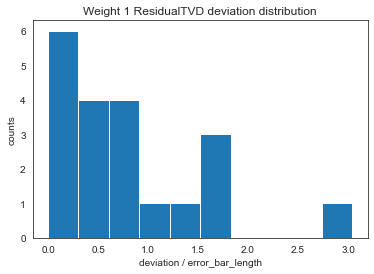

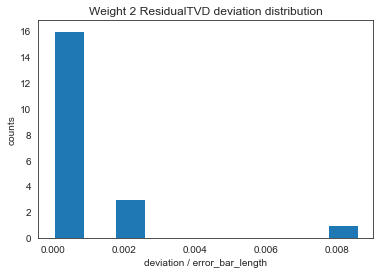

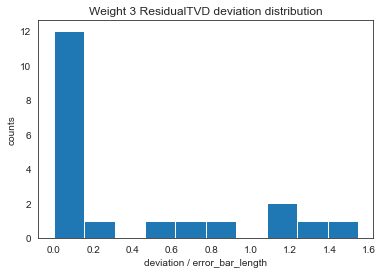

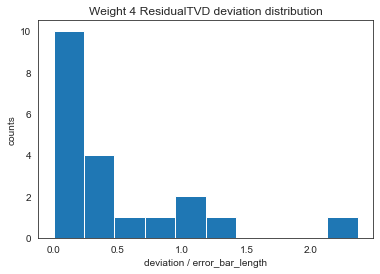

In [12]:
test_errorbars({'0000': 0.45, '0001': 0.05, '1111': 0.5}) # weight 1 movement 

Base weight-1 disturbance = 0
Base weight-2 disturbance = 0.0499994
Base weight-3 disturbance = 5.68003e-07
Base weight-4 disturbance = 0
Check 1 of 20
Weight-1 disturbance = 1.38778e-17 +/- 0.000320143  (deviation=4.321370412922579e-14)
Weight-2 disturbance = 0.0501998 +/- 0.00190977  (deviation=0.1048497139707642)
Weight-3 disturbance = 2.2448e-07 +/- 0.000111828  (deviation=0.003044661006617764)
Weight-4 disturbance = 0 +/- 0.00137199  (deviation=0.0)
Check 2 of 20
Weight-1 disturbance = 0 +/- 0.000326376  (deviation=0.0)
Weight-2 disturbance = 0.0517998 +/- 0.00214741  (deviation=0.8380095916323549)
Weight-3 disturbance = 1.79505e-07 +/- 0.000166554  (deviation=0.002318640379285062)
Weight-4 disturbance = 0 +/- 0.00359922  (deviation=0.0)
Check 3 of 20
Weight-1 disturbance = 0 +/- 0.000292728  (deviation=0.0)
Weight-2 disturbance = 0.0490989 +/- 0.00204205  (deviation=0.4407733279442509)
Weight-3 disturbance = 1.09152e-06 +/- 0.000142393  (deviation=0.0036509258660646043)
Weight-4 

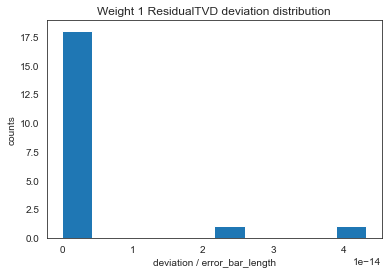

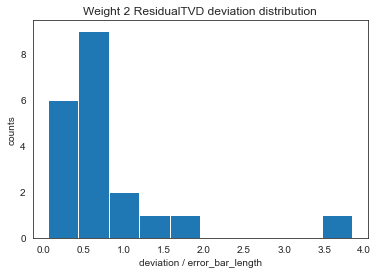

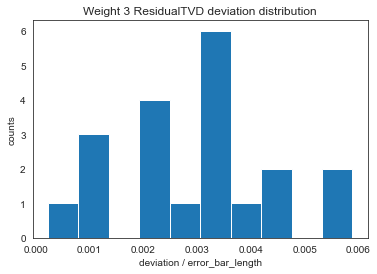

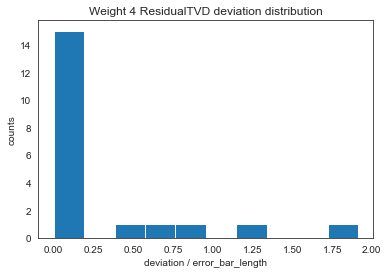

In [13]:
test_errorbars({'0000': 0.45, '0011': 0.05, '1111': 0.5}) # weight 2 movement 

Base weight-1 disturbance = 0
Base weight-2 disturbance = 0
Base weight-3 disturbance = 0.0499999
Base weight-4 disturbance = 1.28928e-07
Check 1 of 20
Weight-1 disturbance = 0.0107 +/- 0.00737062  (deviation=1.4515119564371375)
Weight-2 disturbance = -4.86884e-08 +/- 0.000275193  (deviation=0.00017628385990157717)
Weight-3 disturbance = 0.0394992 +/- 0.00669392  (deviation=1.5684587035086426)
Weight-4 disturbance = 8.78201e-07 +/- 0.0007964  (deviation=0.0009396458817763907)
Check 2 of 20
Weight-1 disturbance = 0.00369893 +/- 0.00563239  (deviation=0.6566092783354704)
Weight-2 disturbance = 8.06074e-07 +/- 0.000272582  (deviation=0.0029463681967091693)
Weight-3 disturbance = 0.0480998 +/- 0.00516763  (deviation=0.3676228193039768)
Weight-4 disturbance = 4.95954e-07 +/- 0.00359656  (deviation=0.00010202075217761323)
Check 3 of 20
Weight-1 disturbance = 0.004 +/- 0.00564926  (deviation=0.7079323793674774)
Weight-2 disturbance = -7.03393e-08 +/- 0.000273583  (deviation=0.0002561679830795

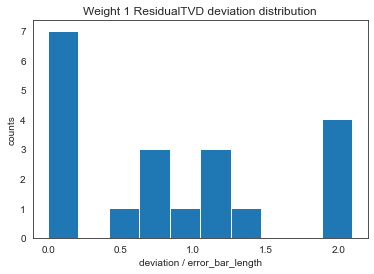

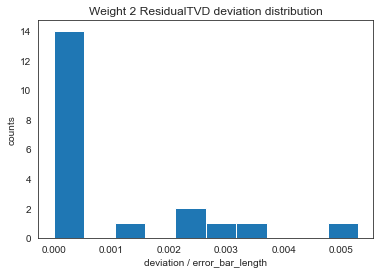

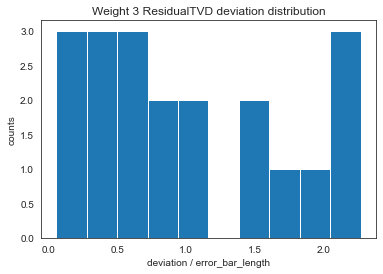

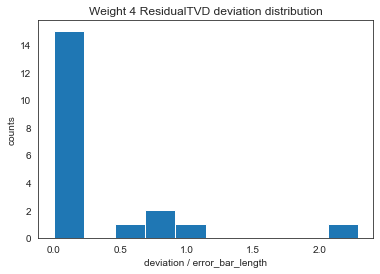

In [14]:
test_errorbars({'0000': 0.45, '0111': 0.05, '1111': 0.5}) # weight 3 movement 

Base weight-1 disturbance = 0
Base weight-2 disturbance = 0
Base weight-3 disturbance = 0
Base weight-4 disturbance = 0.05
Check 1 of 20
Weight-1 disturbance = 0 +/- 0.0002231  (deviation=0.0)
Weight-2 disturbance = 0 +/- 0.000230238  (deviation=0.0)
Weight-3 disturbance = 0 +/- 0.000324488  (deviation=0.0)
Weight-4 disturbance = 0.0395 +/- 0.00661195  (deviation=1.5877929004641103)
Check 2 of 20
Weight-1 disturbance = 0 +/- 0.000222987  (deviation=0.0)
Weight-2 disturbance = 0 +/- 0.000269416  (deviation=0.0)
Weight-3 disturbance = 2.77556e-17 +/- 0.000316966  (deviation=8.729092859246193e-14)
Weight-4 disturbance = 0.0481 +/- 0.0066116  (deviation=0.28733032462986097)
Check 3 of 20
Weight-1 disturbance = 1.38778e-17 +/- 0.000223029  (deviation=6.194648809883684e-14)
Weight-2 disturbance = -6.93889e-18 +/- 0.000275509  (deviation=2.5094680927992896e-14)
Weight-3 disturbance = -6.93889e-18 +/- 0.000315479  (deviation=2.192526972759921e-14)
Weight-4 disturbance = 0.0451 +/- 0.00661162  

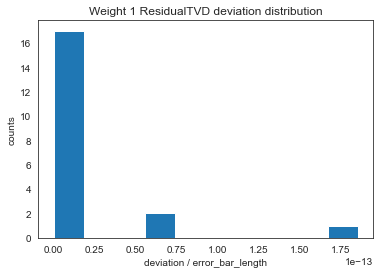

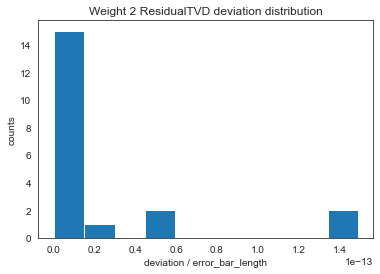

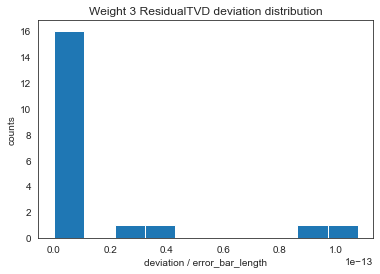

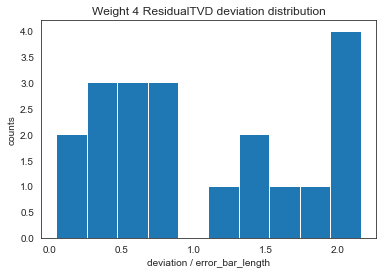

In [15]:
test_errorbars({'0000': 0.45, '1111': 0.55}) # weight 4 movement 